# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2022spring-ta@googlegroups.com

Slide:    [Link](https://speech.ee.ntu.edu.tw/~hylee/ml/2021-spring.php)　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)

# Set up the environment


## Package installation

```python
import sys
!{sys.executable} -m pip install -q qqdm
```

## Downloading data

Get data from: [Colab](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW08/HW08.ipynb#scrollTo=1hui5EYoWzB4)

```python
!tar zxvf data-bin.tar.gz; mv data-bin data
```
```bash
data-bin/
data-bin/testingset.npy
data-bin/trainingset.npy
```

# Import packages

In [ ]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [ ]:

train = np.load('data/trainingset.npy', allow_pickle=True)
test = np.load('data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

In [ ]:
image_height = train.shape[1]
image_width = train.shape[2]

## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [ ]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(), 
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(), 
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 64 * 64 * 3), 
            nn.Tanh(),
            nn.Unflatten(1, (3, image_height, image_width))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4, stride=2, padding=1),        
            nn.ReLU(),
			      nn.Conv2d(in_channels=24, out_channels=48, kernel_size=4, stride=2, padding=1),         
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=12, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

use_cnn = True
class VAE(nn.Module):
    def __init__(self, use_cnn:bool=True):
        super(VAE, self).__init__()
        self.use_cnn = use_cnn
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Sequential(
            nn.Flatten(),
            # in_features: (24, 16, 16) - the output shape of encoder
            # out_features: (48, 8, 8) - the input shape of the decoder (output shape of `enc_out_1` or `enc_out_2`)
            # output_size = [(input_size - kernel_size + 2*padding) / stride] + 1

            nn.Linear(in_features=24 * 16 * 16, out_features=48 * 8 * 8),
            nn.Unflatten(1, (48, 8, 8))
        )
        self.fc_logvar = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=24 * 16 * 16, out_features=48 * 8 * 8),
            nn.Unflatten(1, (48, 8, 8))
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=12, out_channels=3, kernel_size=4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        # import ipdb; ipdb.set_trace()
        if self.use_cnn==True:
            return self.enc_out_1(h1), self.enc_out_2(h1)
        else:
            return self.fc_mu(h1), self.fc_logvar(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        self.image_height = x.shape[-2]
        self.image_width = x.shape[-1]
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generated images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [ ]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [ ]:
# Training hyperparameters
num_epochs = 50
batch_size = 2000
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'cnn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training loop

For `VAE`:

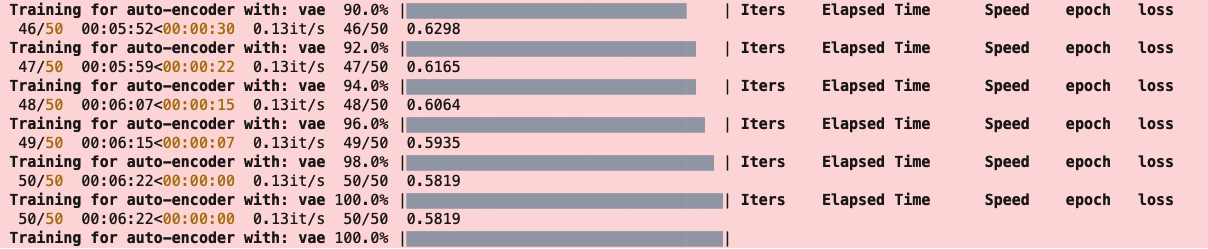

In [ ]:
# Define the training hyperparameters. These variables will determine how the model is trained.
num_epochs = 50  # The number of times the entire training dataset will be passed forward and backward through the neural network
batch_size = 2000  # The number of training examples in one forward/backward pass (one epoch). The higher the batch size, the more memory space you'll need.
learning_rate = 1e-3  # Determines the step size at each iteration while moving toward a minimum of a loss function

# Prepare the training data
x = torch.from_numpy(train)  # Convert the training data into PyTorch tensors
train_dataset = CustomTensorDataset(x)  # Create a dataset from these tensors

# Implement a sampler for batching of the training data
train_sampler = RandomSampler(train_dataset)  # Define a strategy to draw samples from the dataset. Here, we will draw samples randomly.
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)  # Combines a dataset and a sampler, and provides single or multi-process iterators over the dataset.

# Define the model architecture
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}  # Dictionary containing the class instances of the model types
model_type = 'cnn'  # A string that selects a model type from a dictionary of possible models: {'cnn', 'fcn', 'vae', 'compose'}
# if model_type == 'compose':
#     models = [m.cuda() for _, m in model_classes.items()]
# else:
#     models = [model_classes[model_type].cuda()]  # Create the model and move it to GPU for computation

model = model_classes[model_type].cuda()
# models = [model]
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss function, often used in regression problems
# optimizers = [torch.optim.Adam(model.parameters(), lr=learning_rate) for model in models]  # Adam optimizer, a popular variant of gradient descent which also considers the second moments of the gradient
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizers = [optimizer]

# Set the model to training mode. This is necessary as some layers like dropout, batchnorm have different behaviors in training and evaluation.
model.train()
# for model in models:
#     model.train()

In [ ]:
# Initialize the best loss as infinite. This will be used to track the minimum loss during training.
best_loss = np.inf

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', f'Training for auto-encoder with: {model_type}'))

for epoch in qqdm_train:
    tot_loss = list()
    
    for data in train_dataloader:

        img = data.float().cuda()
        
        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss0 = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss0 = criterion(output, img)
        
        # ===================backward====================
        optimizer.zero_grad()
        loss0.backward()
        optimizer.step()

        # Append the loss to the list of losses
        tot_loss.append(loss0.detach().item())
        # tot_loss.append(loss.item())
            
    # Calculate the mean loss for this epoch
    mean_loss = np.mean(tot_loss)
    
    # If this is the best model so far, update the best_loss and save the model
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, f'best_model_{model_type}.pt')
    
    # Log the epoch number and loss
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    
    # Save the model at the end of each epoch
    torch.save(model, f'last_model_{model_type}.pt')


In [ ]:
best_loss = np.inf
# model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        img = data.float().cuda()
        # if model_type in ['fcn']:
        #     img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [ ]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'last_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = 'prediction.csv'

In [ ]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    output = model(img)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1, 2, 3])
    anomality.append(loss)

In [ ]:
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')